# Image Classification Task from [Zindi](https://zindi.africa/competitions/kenyan-sign-language-classification-challenge/data)
# Task Mate Kenyan Sign Language Classification Challenge
The objective of this competition is to classify the ten different Sign Language signs present in the images.
The following approaches was followed:
- implementing data augmentation with albumentation
- using timm library to import `convnext_xlarge_384_in22ft1k` model

In [1]:
from fastai.vision.all import *
from fastai.vision.learner import _update_first_layer

In [2]:
!pip install timm

     |████████████████████████████████| 431 kB 921 kB/s            


In [3]:
from fastcore.xtras import Path

from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_one_cycle

from fastai.data.block import DataBlock, CategoryBlock
from fastai.data.core import Datasets
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, Normalize, RandomSplitter, GrandparentSplitter, RegexLabeller, ToTensor, IntToFloatTensor, Categorize, parent_label

from fastai.learner import Learner
from fastai.losses import LabelSmoothingCrossEntropy
from fastai.metrics import error_rate, accuracy

from fastai.vision.augment import aug_transforms, RandomResizedCrop, Resize, FlipItem
from fastai.vision.core import PILImage, imagenet_stats
from fastai.vision.data import ImageBlock
from fastai.vision.learner import cnn_learner, create_head, create_body, num_features_model, default_split, has_pool_type, apply_init, _update_first_layer

import torch
from torch import nn
from torchvision.models.resnet import resnet18

from timm import create_model

In [4]:
image_path = '../input/kenya-language-sign-dataset/Images'

In [5]:
import numpy as np
import pandas as pd

In [6]:
train = pd.read_csv("../input/kenya-language-sign-dataset/dataset/Train.csv")
test = pd.read_csv("../input/kenya-language-sign-dataset/dataset/Test.csv")

In [7]:
batch_tfms = [*aug_transforms(size=384, max_warp=0, max_lighting=0.18,max_rotate=10), Normalize.from_stats(*imagenet_stats)]
#item_tfms = [CropPad(860)]

In [8]:
import albumentations as A

# Source: https://forums.fast.ai/t/albumentation-transformations-for-train-and-test-dataset/82642
class AlbumentationsTransform(RandTransform):
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)
    
def get_train_aug(): 
    return A.Compose([
#         A.RandomResizedCrop(cfg.input_dims,cfg.input_dims), 
        A.Resize(384, 384, p=1.0),
        A.HorizontalFlip(always_apply=True, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.1, rotate_limit=10, p=0.5),
        A.IAAPerspective(scale=(0.02, 0.04), p=0.5),
        A.RandomBrightnessContrast(0.1, 0.1, p=0.5),
        A.CLAHE(always_apply=True),
        A.OneOf([A.HueSaturationValue(0.2, 0.2, 0.2, p=0.5)
                ],p=0.4),
        A.OneOf([A.CoarseDropout(),
                 A.Cutout()], p=0.5)
    ])

def get_valid_aug():
    return A.Compose([A.Resize(384, 384, p=1.0), A.CLAHE(always_apply=True)], p=1.0)

item_tfms = AlbumentationsTransform(get_train_aug(), get_valid_aug())
#batch_tfms = [Normalize.from_stats(*imagenet_stats)]

/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:691: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


# Data Augmentation

In [9]:
from fastai.vision.data import ImageDataLoaders
data = ImageDataLoaders.from_df(train, image_path,
                              valid_pct=0.17,
                              item_tfms=item_tfms,
                              bs=16, batch_tfms=batch_tfms, 
                             suff='.jpg', seed=42)

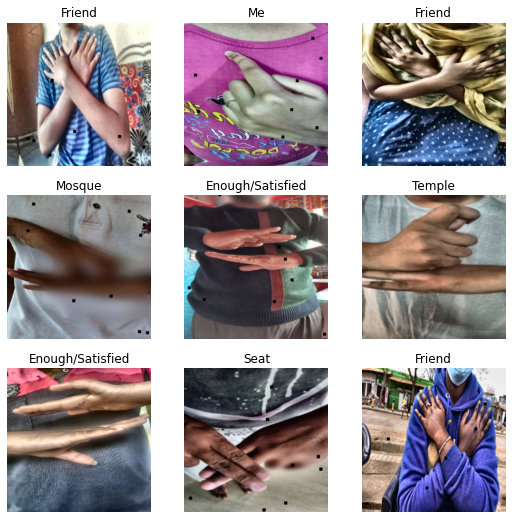

In [10]:
# Look at some examples
data.show_batch() 

# Create a baseline model using resnet

# Make use of External model

In [11]:

def create_body(arch, n_in=3, pretrained=True, cut=None):
    "Cut off the body of a typically pretrained `arch` as determined by `cut`"
    model = arch(pretrained=pretrained)
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if   isinstance(cut, int):      return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else:                           raise NamedError("cut must be either integer or a function")
        

def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")
        
def cnn_learner(dls, arch, loss_func=None, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_out=None, normalize=True, **kwargs):
    "Build a convnet style learner from `dls` and `arch`"
    if config is None: config = {}
    meta = model_meta.get(arch, _default_meta)
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if normalize: _add_norm(dls, meta, pretrained)
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = create_cnn_model(arch, n_out, ifnone(cut, meta['cut']), pretrained, y_range=y_range, **config)
    learn = Learner(dls, model, loss_func=loss_func, splitter=ifnone(splitter, meta['split']), **kwargs)
    if pretrained: learn.freeze()
    return learn

def create_timm_model(arch:str, n_out, cut=None, pretrained=True, n_in=3, init=nn.init.kaiming_normal_, custom_head=None,
                     concat_pool=True, **kwargs):
    "Create custom architecture using `arch`, `n_in` and `n_out` from the `timm` library"
    body = create_timm_body(arch, pretrained, None, n_in)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children()))
        head = create_head(nf, n_out, concat_pool=concat_pool, **kwargs)
    else: head = custom_head
    model = nn.Sequential(body, head)
    if init is not None: apply_init(model[1], init)
    return model


def timm_learner(dls, arch:str, loss_func=None, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_out=None, normalize=True, **kwargs):
    "Build a convnet style learner from `dls` and `arch` using the `timm` library"
    if config is None: config = {}
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = create_timm_model(arch, n_out, default_split, pretrained, y_range=y_range, **config)
    learn = Learner(dls, model, loss_func=loss_func, splitter=default_split, **kwargs)
    if pretrained: learn.freeze()
    return learn

In [12]:
#import timm
#from pprint import pprint
#model_names = timm.list_models()
#pprint(model_names)

In [13]:
learn = timm_learner(data, 'convnext_xlarge_384_in22ft1k', loss_func=CrossEntropyLossFlat(), metrics=[accuracy, error_rate])

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_xlarge_22k_1k_384_ema.pth" to /root/.cache/torch/hub/checkpoints/convnext_xlarge_22k_1k_384_ema.pth


In [14]:
learn.model_dir = '/kaggle/working/models'
#lr = learn.lr_find()
#print(lr)

In [15]:
# Fit
num_epochs = 15
learn.fit_one_cycle(num_epochs,  0.001745)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.186301,0.575552,0.818267,0.181733,12:29
1,0.545615,0.333894,0.913371,0.086629,12:16
2,0.401300,0.306268,0.902072,0.097928,12:16
3,0.348436,0.221263,0.936911,0.063089,12:16
4,0.231907,0.237459,0.945386,0.054614,12:16
5,0.270095,0.231497,0.932203,0.067797,12:16
6,0.180106,0.230162,0.948211,0.051789,12:16
7,0.164523,0.216306,0.952919,0.047081,12:16
8,0.133176,0.219465,0.951036,0.048964,12:16
9,0.071308,0.230048,0.952919,0.047081,12:16


# Prediction

In [16]:
# Make a test dataloader and get predictions
tdl = learn.dls.test_dl(test['img_IDS'].map(lambda s: '../input/kenya-language-sign-dataset/dataset/Images/Images/'+s+'.jpg').values)
preds = learn.get_preds(dl=tdl)

In [17]:
sub=pd.read_csv('../input/kenya-language-sign-dataset/dataset/SampleSubmission.csv')
sub.head()

,img_IDS,Church,Enough/Satisfied,Friend,Love,Me,Mosque,Seat,Temple,You
0,ImageID_USRB8QNG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ImageID_SZ8D1ZJI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ImageID_4OJO2F8J,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ImageID_IEE4XV0B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ImageID_BP0O0WZ9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
c = list(data.vocab.o2i)

In [19]:
import os
submission = pd.DataFrame()
submission["ID"] = test["img_IDS"]
submission[c] = sub.iloc[:, 1:]
submission[c] = preds[0].numpy()
submission.head()

,ID,Church,Enough/Satisfied,Friend,Love,Me,Mosque,Seat,Temple,You
0,ImageID_USRB8QNG,1.467773e-06,1.411982e-06,1.422175e-07,9.935939e-07,1.052151e-08,1.642931e-05,2.261894e-07,9.999793e-01,2.699372e-08
1,ImageID_SZ8D1ZJI,3.668792e-08,9.999912e-01,8.525951e-06,6.098952e-09,1.791870e-08,2.910341e-08,1.775873e-07,1.235535e-08,2.616751e-08
2,ImageID_4OJO2F8J,6.519577e-05,1.350992e-05,1.334787e-06,3.050390e-06,5.729220e-08,9.999132e-01,1.268209e-07,3.510271e-06,3.243265e-09
3,ImageID_IEE4XV0B,7.699753e-05,1.591142e-07,7.638325e-07,3.022548e-07,1.343960e-06,9.999158e-01,4.242598e-06,2.477962e-07,1.220602e-08
4,ImageID_BP0O0WZ9,3.851269e-07,6.213917e-07,2.479824e-07,3.393017e-07,1.462434e-06,4.877982e-07,7.701186e-06,4.468309e-05,9.999441e-01


In [20]:
# Save
submission.to_csv('res101d_1.csv', index=False)